# Parameter-Efficient Fine-Tuning (PEFT): A Guide

This notebook summarizes the usage of the HuggingFace `transformers` library in combination with `peft`.
Specifically, low-rank adaptation is used to fine-tune an LLM for a text classification task.

Table of contents:

- [Dataset](#dataset)
  - [Custom Dataset](#custom-dataset)
  - [HuggingFace Dataset](#huggingface-dataset)
- [Preprocessing the Dataset](#preprocessing-the-dataset)
  - [Tokenization](#tokenization)
  - [EDA: Basic Exploration](#eda-basic-exploration)
  - [EDA: Feature Maps](#eda-feature-maps)
- [Model Setup](#model-setup)
- [Training](#training)
  - [Tensorboard](#tensorboard)
- [Evaluation and Inference](#evaluation-and-inference)
- [Error Analysis](#error-analysis)
- [Packaging and Inference](#packaging-and-inference)

## Dataset

In [1]:
from datasets import Dataset, load_dataset

from dummy_dataset import (
    get_dummy_news_dataset_list,
    get_dummy_news_dataset_filepath,
)

### Custom Dataset

In [2]:
# We can load a custom dataset: from list, CSV, etc.
dummy_news = get_dummy_news_dataset_list()
dummy_news_filepath = get_dummy_news_dataset_filepath()
#dataset = Dataset.from_list(dummy_news)
dataset = load_dataset("csv", data_files=dummy_news_filepath)["train"]

Generating train split: 0 examples [00:00, ? examples/s]

In [3]:
print(dataset.shape)
print(dataset.features)
print(dataset[0])

(20, 3)
{'Headline': Value(dtype='string', id=None), 'Summary': Value(dtype='string', id=None), 'Topic': Value(dtype='string', id=None)}
{'Headline': 'President Signs New Climate Accord', 'Summary': 'The president has committed to new international environmental targets aimed at reducing emissions by 2030.', 'Topic': 'politics'}


### HuggingFace Dataset

In [4]:
# Load the sms_spam dataset
# See: https://huggingface.co/datasets/sms_spam
# The sms_spam dataset only has a train split,
# so we use the train_test_split method to split it into train and test
dataset = load_dataset("sms_spam", split="train").train_test_split(
    test_size=0.2, shuffle=True, seed=42
)

splits = ["train", "test"]

In [5]:
print(dataset["train"].shape)
print(dataset["test"].shape)
print(dataset["train"].features)
print(dataset["train"][0])

(4459, 2)
(1115, 2)
{'sms': Value(dtype='string', id=None), 'label': ClassLabel(names=['ham', 'spam'], id=None)}
{'sms': 'K..then come wenever u lik to come and also tel vikky to come by getting free time..:-)\n', 'label': 0}


## Preprocessing the Dataset

### Tokenization

In [6]:
from transformers import AutoTokenizer

In [7]:
# Load a tokenizer for the sms_spam dataset
# We should use a tokenizer that matches the model we want to use later
tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased")

In [8]:
print(f"Vocabulary size: {tokenizer.vocab_size}") # 30k
print(f"Context length: {tokenizer.model_max_length}") # 512

Vocabulary size: 30522
Context length: 512


In [10]:
# We get back a dictionary with the encoded text:
# # {'input_ids': [...], 'attention_mask': [...]}
# The input_ids are the tokenized text ids (integers), and the attention_mask indicates which tokens are padding 
# (1: not padding, 0: padding -> ignore)
text = "This is a test message for the sms_spam dataset."
encoded_text = tokenizer(text)
print(encoded_text)

{'input_ids': [101, 2023, 2003, 1037, 3231, 4471, 2005, 1996, 22434, 1035, 12403, 2213, 2951, 13462, 1012, 102], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}


In [12]:
# We see that the the input ids map to the vocabulary of the tokenizer
# Subword tokenization is used.
# Special tokens are added, such as [CLS] and [SEP] for BERT-like models.
# [CLS] is the classification token (always in the beginning), and [SEP] is the separator token.
tokens = tokenizer.convert_ids_to_tokens(encoded_text.input_ids)
print(tokens)
print(tokenizer.convert_tokens_to_string(tokens))

['[CLS]', 'this', 'is', 'a', 'test', 'message', 'for', 'the', 'sms', '_', 'spa', '##m', 'data', '##set', '.', '[SEP]']
[CLS] this is a test message for the sms _ spam dataset. [SEP]


In [ ]:
# Tokenize the dataset in a dictionary format
# We add to the dataset the columns input_ids and attention_mask
tokenized_dataset = {}
for split in splits:
    # We can also use padding="max_length", which pads to tokenizer.model_max_length
    # or padding=True, which pads to the longest sequence in the batch
    # Truncation is always tokenizer.model_max_length
    # NOTE: Padding slows the training considerably
    tokenized_dataset[split] = dataset[split].map(
        lambda x: tokenizer(x["sms"], truncation=True, padding=True), batched=True
    )

# Set the format of the dataset to PyTorch tensors
tokenized_dataset["train"].set_format("torch")
tokenized_dataset["test"].set_format("torch")

Map:   0%|          | 0/1115 [00:00<?, ? examples/s]

In [14]:
# Check sizes and features of tokenized datasets
print(tokenized_dataset["train"])
print(tokenized_dataset["test"])

Dataset({
    features: ['sms', 'label', 'input_ids', 'attention_mask'],
    num_rows: 4459
})
Dataset({
    features: ['sms', 'label', 'input_ids', 'attention_mask'],
    num_rows: 1115
})


In [15]:
# Get the label features
print(tokenized_dataset["train"].features["label"])

ClassLabel(names=['ham', 'spam'], id=None)


In [16]:
# Label string <-> int mapping
id2label = {0: "ham", 1: "spam"}
label2id = {"ham": 0, "spam": 1}

### EDA: Basic Exploration

Basic Exploratory Data Analysis:

- Are there duplicates or empty texts?
- How is the label distribution?
- How is the text length distribution for each class?
- Which are the most frequent words?

In [17]:
from collections import Counter
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud

In [18]:
# Look for duplicated and empty messages
df = pd.DataFrame(dataset["train"])
print("Empty messages:", df["sms"].str.strip().eq("").sum())
print("Duplicate messages:", df["sms"].duplicated().sum())

Empty messages: 0
Duplicate messages: 282


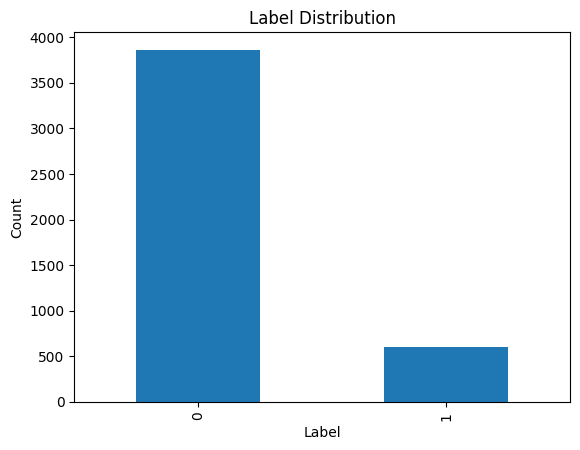

In [19]:
# Count class distribution
label_counts = Counter(dataset["train"]["label"])
pd.Series(label_counts).plot(kind="bar", title="Label Distribution")
plt.xlabel("Label")
plt.ylabel("Count")
plt.show()

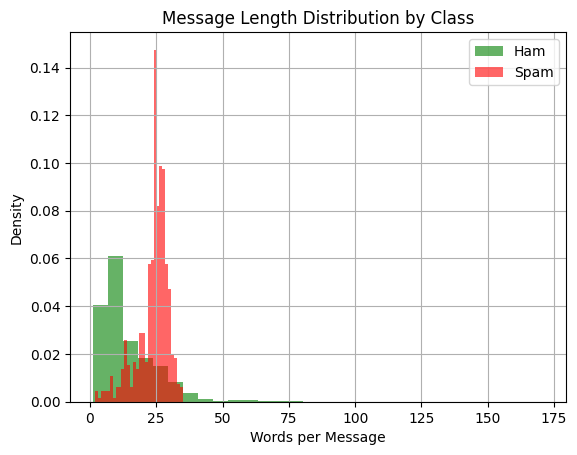

In [20]:
# Message length distribution
texts = dataset["train"]["sms"]
labels = dataset["train"]["label"]
lengths_spam = [len(t.split()) for t, l in zip(texts, labels) if l == 1]
lengths_ham  = [len(t.split()) for t, l in zip(texts, labels) if l == 0]
plt.hist(lengths_ham, bins=30, alpha=0.6, label="Ham", color="green", density=True)
plt.hist(lengths_spam, bins=30, alpha=0.6, label="Spam", color="red", density=True)

plt.title("Message Length Distribution by Class")
plt.xlabel("Words per Message")
plt.ylabel("Density")
plt.legend()
plt.grid(True)
plt.show()

<Axes: xlabel='label', ylabel='length'>

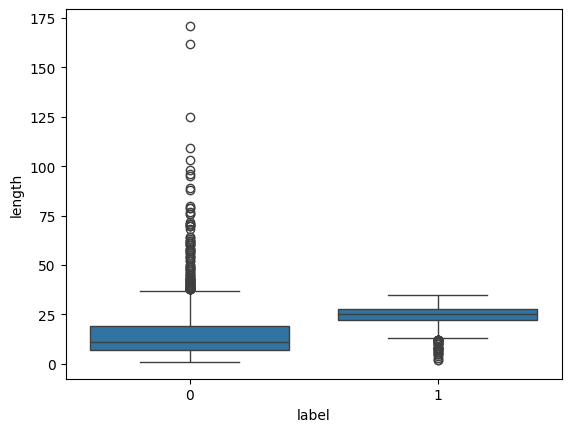

In [21]:
# Boxplot of message lengths by label
df["length"] = df["sms"].str.split().apply(len)
sns.boxplot(x="label", y="length", data=df)

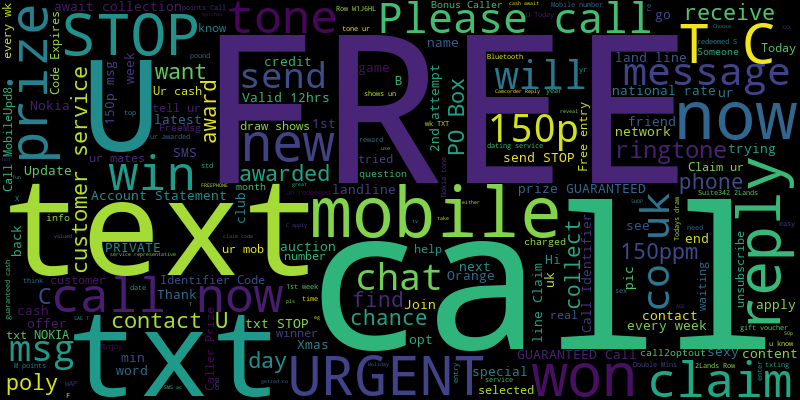

In [22]:
# Word cloud: visual representation of most common words
spam_texts = " ".join(
    sms for sms, label in zip(dataset["train"]["sms"], dataset["train"]["label"])
    if label == 1  # assuming 1 is 'spam'
)
WordCloud(width=800, height=400).generate(spam_texts).to_image()


### EDA: Feature Maps

If we are going to implement a text classification application, we can understand the pretrained LLM as a feature extractor. Since the LLMs output a sequence of hidden states, it is a usual convention to pick the first token/element as the `[CLS]` token/element. This will be a hidden vector of a given size and can be used for classification.

This section extracts the hidden states of the texts and maps them to a 2D space. Then, a hexplot is shown for each class, to see if there are visually discernible differences between class groups.

Note that the output vector of the model will be `(batch_size, seq_len, hidden_size)`; in the particular case of DistilBERT: `hidden_size = 768`.

In [27]:
from transformers import AutoModelForSequenceClassification
import torch

from umap import UMAP
import numpy as np
from sklearn.preprocessing import MinMaxScaler

In [28]:
def extract_hidden_states(batch, model, tokenizer, device="cpu"):
    # Filter only inputs required by the model
    # tokenizer.model_input_names: ['input_ids', 'attention_mask']
    input_batch = {k: batch[k] for k in tokenizer.model_input_names if k in batch}
    
    # Pad and convert to tensors
    inputs = tokenizer.pad(input_batch, return_tensors="pt", padding=True)
    inputs = {k: v.to(device) for k, v in inputs.items()}

    # Forward pass with no gradient computation and output hidden states
    with torch.no_grad():
        outputs = model(**inputs, output_hidden_states=True)

    # Extract [CLS] token embedding from last hidden state
    last_hidden_state = outputs.hidden_states[-1]
    cls_embeddings = last_hidden_state[:, 0].cpu().numpy()

    return {"hidden_state": cls_embeddings.tolist()}

In [29]:
# Transformer model
model = AutoModelForSequenceClassification.from_pretrained(
    "distilbert-base-uncased",
    num_labels=len(id2label),
)

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [30]:
tokenized_dataset_hidden_train = tokenized_dataset["train"].map(
    lambda batch: extract_hidden_states(batch, model, tokenizer, device="cpu"),
    batched=True,
    batch_size=32,
)

Map:   0%|          | 0/4459 [00:00<?, ? examples/s]

You're using a DistilBertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


In [34]:
# Convert the hidden states to numpy arrays for further processing
X_train = np.array(tokenized_dataset_hidden_train["hidden_state"])
y_train = np.array(tokenized_dataset_hidden_train["label"])
print(X_train.shape)

(4459, 768)


C:\Users\A200239740\AppData\Local\Temp\ipykernel_4992\3789766843.py:2: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  X_train = np.array(tokenized_dataset_hidden_train["hidden_state"])
C:\Users\A200239740\AppData\Local\Temp\ipykernel_4992\3789766843.py:3: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_train = np.array(tokenized_dataset_hidden_train["label"])


In [35]:
# Scale features to [0,1] range
X_scaled = MinMaxScaler().fit_transform(X_train)

# Initialize and fit UMAP
mapper = UMAP(n_components=2, metric="cosine").fit(X_scaled)

# Create a DataFrame of 2D embeddings
df_emb = pd.DataFrame(mapper.embedding_, columns=["X", "Y"])
df_emb["label"] = y_train
df_emb.head()

c:\Users\A200239740\AppData\Local\anaconda3\envs\genai\lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


,X,Y,label
0,11.088692,1.770197,0
1,6.798233,5.031321,0
2,9.431431,3.525459,0
3,6.551299,3.586686,0
4,2.979292,-0.069549,1


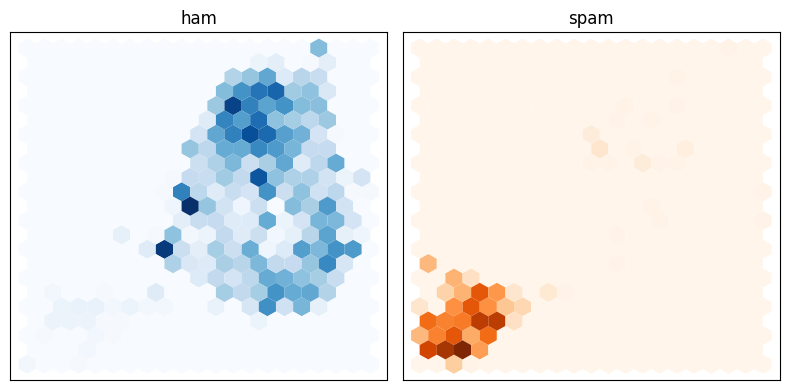

In [36]:
fig, axes = plt.subplots(1, 2, figsize=(8,4))
axes = axes.flatten()
cmaps = ["Blues", "Oranges"]
labels = tokenized_dataset["train"].features["label"].names

for i, (label, cmap) in enumerate(zip(labels, cmaps)):
    df_emb_sub = df_emb.query(f"label == {i}")
    axes[i].hexbin(df_emb_sub["X"], df_emb_sub["Y"], cmap=cmap,
                   gridsize=20, linewidths=(0,))
    axes[i].set_title(label)
    axes[i].set_xticks([]), axes[i].set_yticks([])

plt.tight_layout()
plt.show()

## Model Setup

In [56]:
from transformers import AutoModelForSequenceClassification
from peft import LoraConfig, TaskType
from transformers import BitsAndBytesConfig
from peft import get_peft_model

In [ ]:
# Quantization config (4-bit for minimal memory usage)
# WARNING: This requires the `bitsandbytes` library to be installed 
# and Intel CPU and/or 'cuda', 'mps', 'hpu', 'xpu', 'npu'
bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,                      # Activate 4-bit quantization
    bnb_4bit_use_double_quant=True,         # Use double quantization for better accuracy
    bnb_4bit_compute_dtype="bfloat16",      # Use bf16 if supported, else float16
    bnb_4bit_quant_type="nf4",              # Quantization type: 'nf4' is best for LLMs
)

# Transformer model
model = AutoModelForSequenceClassification.from_pretrained(
    "distilbert-base-uncased",
    num_labels=len(id2label),
    id2label=id2label,
    label2id=label2id,
    #quantization_config=bnb_config,
    device_map="auto"  # Optional: distributes across GPUs if available
)

# LoRA configuration
lora_config = LoraConfig(
    r=8,                                    # Low-rank dimensionality
    lora_alpha=16,                          # Scaling factor
    target_modules=["q_lin", "v_lin"],      # Which submodules to apply LoRA to (name depends on model, see below)
    lora_dropout=0.1,                       # Dropout for LoRA layers
    bias="none",                            # Do not train bias
    task_type=TaskType.SEQ_CLS              # Task type: sequence classification
)

# Freeze all the model parameters
# THIS IS NOT REALLY NECESSARY IF WE CALL get_peft_model()!
for param in model.parameters():
    param.requires_grad = False

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [58]:
# Get the PEFT model with LoRA
lora_model = get_peft_model(model, lora_config)

In [59]:
# If we need to know the target_modules of the LoraConfig, we can try this:
names = []
for name, _ in model.named_modules():
    if "query" in name or "q" in name or "attn" in name:
        names.append(str(name))


In [60]:
names[:5]

['distilbert.transformer.layer.0.attention.q_lin',
 'distilbert.transformer.layer.0.attention.q_lin.base_layer',
 'distilbert.transformer.layer.0.attention.q_lin.lora_dropout',
 'distilbert.transformer.layer.0.attention.q_lin.lora_dropout.default',
 'distilbert.transformer.layer.0.attention.q_lin.lora_A']

## Training

In [61]:
import numpy as np
from transformers import TrainingArguments, Trainer
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

In [62]:
# Define the metrics we'd like to have
def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    preds = np.argmax(predictions, axis=1)

    acc = accuracy_score(labels, preds)
    precision, recall, f1, _ = precision_recall_fscore_support(
        labels, preds, average="macro", zero_division=0
    )

    return {
        "accuracy": acc,
        "precision": precision,
        "recall": recall,
        "f1": f1
    }

In [63]:
# Define training arguments
training_args = TrainingArguments(
    learning_rate=2e-3,
    weight_decay=0.01,
    num_train_epochs=3,
    eval_strategy="epoch",  # alternatively "steps" and add argument eval_steps=200
    save_strategy="epoch",
    output_dir="./checkpoints",
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    load_best_model_at_end=True,
    logging_dir="./logs",
    report_to="tensorboard",   # enable TensorBoard, if desired
)

# Initialize the Trainer
trainer = Trainer(
    model=lora_model,
    args=training_args,
    train_dataset=tokenized_dataset["train"],
    eval_dataset=tokenized_dataset["test"],
    processing_class=tokenizer,
    compute_metrics=compute_metrics,
)

No label_names provided for model class `PeftModelForSequenceClassification`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.


In [64]:
# Check model performance on test split before training
trainer.evaluate()

c:\Users\A200239740\AppData\Local\anaconda3\envs\genai\lib\site-packages\torch\utils\data\dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


{'eval_loss': 0.6804953813552856,
 'eval_model_preparation_time': 0.0073,
 'eval_accuracy': 0.7300448430493274,
 'eval_precision': 0.49842726991145714,
 'eval_recall': 0.49795392332596883,
 'eval_f1': 0.49578967136150237,
 'eval_runtime': 130.6226,
 'eval_samples_per_second': 8.536,
 'eval_steps_per_second': 1.072}

In [ ]:
# TRAIN! This should take around 20m - 2h on a modern (2023) CPU
trainer.train()

c:\Users\A200239740\AppData\Local\anaconda3\envs\genai\lib\site-packages\torch\utils\data\dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Epoch,Training Loss,Validation Loss


### Tensorboard

Tensorboard logs can be checked as follows (also while training):

```bash
tensorboard --logdir=./logs
# Then open http://localhost:6006 in the browser
```

## Evaluation and Inference

In [ ]:
# Show the performance of the model on the test set
trainer.evaluate()

c:\Users\A200239740\AppData\Local\anaconda3\envs\genai\lib\site-packages\torch\utils\data\dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


{'eval_loss': 0.04926690459251404,
 'eval_model_preparation_time': 0.0054,
 'eval_accuracy': 0.9856502242152466,
 'eval_precision': 0.9796554385658323,
 'eval_recall': 0.9576611502494199,
 'eval_f1': 0.968290081763242,
 'eval_runtime': 115.994,
 'eval_samples_per_second': 9.613,
 'eval_steps_per_second': 1.207,
 'epoch': 3.0}

In [ ]:
from typing import Dict, Any, Optional

# Inference
def predict(text: str, model: Any, tokenizer: Any, label_mapping: Optional[Dict], device: str ="cpu"):
    # Tokenize input
    inputs = tokenizer(text, return_tensors="pt", truncation=True, padding=True)
    inputs = {k: v.to(device) for k, v in inputs.items()}

    # Run inference
    with torch.no_grad():
        outputs = model(**inputs)
        logits = outputs.logits
        predicted_class_id = logits.argmax(dim=-1).item()

    # Map back to label if mapping provided
    if label_mapping:
        return label_mapping[predicted_class_id]
    else:
        return predicted_class_id

In [ ]:
text = "Congratulations! You've won a free ticket to Bahamas! Call now 123-223!"
model = lora_model.eval()
pred = predict(text, model, tokenizer, id2label, device="cpu")
print(pred)

spam


In [ ]:
text = "I am arriving at the airport at 3pm."
model = lora_model.eval()
pred = predict(text, trainer.model, tokenizer, id2label, device="cpu")
print(pred)

ham


### Save & Load Model

In [ ]:
lora_model.save_pretrained("distilbert-model-spam")

## Error Analysis

## Packaging and Inference